In [24]:
import itertools
from functools import partial
import numpy as np
import scipy.stats
import seaborn
import hyperopt
from hyperopt import hp
from sklearn import ensemble
from sklearn.gaussian_process import GaussianProcess
import contextlib
import time

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# A Primer

### Finding Hyperparameters

[Grid Search?](http://scikit-learn.org/stable/modules/grid_search.html)

```python
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
```

Scales exponentially in number of hyperparameters!

### Random Search > Grid search

[Random Search for Hyper-Parameter Optimization](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)

![random search](./random_search.png)

Random searching is pretty "stupid" though...

### Can we do better?

[Sequential Model-Based Optimization for General Algorithm Configuration](http://www.cs.ubc.ca/~hutter/papers/11-LION5-SMAC.pdf)

[Hyperopt: A Python Library for Optimizing the
Hyperparameters of Machine Learning Algorithms](http://conference.scipy.org/proceedings/scipy2013/pdfs/bergstra_hyperopt.pdf)

In [4]:
def smbo(generator_fn,
         score_fn,
         evaluation_fn,
         num_dims,
         num_initial_points=10,
         num_iter=200,
         num_generated=10000):
    """
    general sequential model based optimization to minimize the result
    of some presumably expensive function

    generator_fn:
    function that takes in the algorithm's history (X and y) and generates a
    number of candidates

    score_fn:
    function that scores candidates given the algorithm's history

    evaluation_fn:
    function that computes the "true" score for a chosen candidate
    """
    # evaluated candidates
    X = []
    # actual scores for the evaluated candidates
    y = []
    for i in range(num_iter):
        if i < num_initial_points:
            best_candidate = generator_fn(X, y, 1, num_dims)[0]
        else:
            candidates = generator_fn(X, y, num_generated, num_dims)
            scores = score_fn(X, y, candidates)
            argmin = min(range(num_generated), key=lambda x: scores[x])
            best_candidate = candidates[argmin]
        actual_result = evaluation_fn(best_candidate)
        X.append(best_candidate)
        y.append(actual_result)
    return dict(
        X=X,
        y=y,
        best=min(y),
    )


def discriminative_smbo(discriminative_model_fn, model_score_fn, **kwargs):
    """
    sequential model based optimization using a discriminative model to
    directly predict how good each candidate is

    discriminative_model_fn:
    function that given X, y, and candidates, predicts mean expected value for
    each candidate, as well as the std of the prediction

    model_score_fn:
    function that takes in the best score so far, candidate prediction means
    and variances, and scores each candidate
    """
    def score_fn(X, y, candidates):
        means, stds = discriminative_model_fn(X, y, candidates)
        return model_score_fn(min(y), means, stds)

    return smbo(score_fn=score_fn, **kwargs)


def generative_smbo(generative_model_fn, percentile, epsilon=1e-8, **kwargs):
    """
    sequential model based optimization using a generative model to
    predict the likelihood that each candidate is in a good or bad region
    of the search space

    generative_model_fn:
    function that given X and candidates, computes the likelihood that each
    candidate is from the X distribution

    percentile:
    scores below this percentile of scores are considered "good"
    """
    def score_fn(X, y, candidates):
        good_idxs = y < np.percentile(y, percentile)
        good_X = X[good_idxs]
        bad_X = X[~good_idxs]
        # generate probability that each candidate is from good distribution
        p_good = generative_model_fn(good_X, candidates)
        # generate probability that each candidate is from bad distribution
        p_bad = generative_model_fn(bad_X, candidates)
        # want to minimize p(bad) / p(good)
        return p_bad / (p_good + epsilon)

    return smbo(score_fn=score_fn, **kwargs)


# Setup

### Assumptions
- search space for each parameter is random uniform between 0 and 1
- 200 iterations for each algorithm

## utils

In [5]:
@contextlib.contextmanager
def timer(title):
    start_time = time.time()
    try:
        yield
    finally:
        duration = time.time() - start_time
        print("%s took %fs" % (title, duration))

## score functions

In [6]:
def random_score(X, y, candidates):
    return np.random.rand(len(candidates))

## generator functions

In [7]:
def random_generator(X, y, num_candidates, num_dims):
    return np.random.rand(num_candidates, num_dims)

## evaluation functions

In [8]:
def branin_hoo(params, noisy=False):
    """
    http://www.sfu.ca/~ssurjano/branin.html
    """
    unscaled_x1, unscaled_x2 = params

    x1 = unscaled_x1 * 15 - 5
    x2 = unscaled_x2 * 15

    a = 1
    b = 5.1 / (4 * np.pi ** 2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8 * np.pi)

    term1 = a * (x2 - b * x1 ** 2 + c * x1 - r) ** 2
    term2 = s * (1 - t) * np.cos(x1)
    return term1 + term2 + s

branin_hoo([(np.pi + 5) / 15, 2.275 / 15])

0.39788735772973816

In [9]:
def branin_hoo_with_useless_dimensions(total_dims):
    assert total_dims > 2

    p1 = np.random.randint(total_dims)
    p2 = np.random.randint(total_dims)

    def inner(params, noisy=False):
        return branin_hoo([params[p1], params[p2]], noisy)

    return inner

## discriminative model functions

In [10]:
def extra_trees_fn(X, y, candidates):
    kwargs = dict(
        n_estimators=10,
        max_depth=6,
        min_samples_split=2,
        min_samples_leaf=1,
        bootstrap=True,
        max_features="sqrt"
    )
    clf = ensemble.ExtraTreesRegressor(**kwargs)
    clf.fit(X, y)
    results = [est.predict(candidates) for est in clf.estimators_]
    means = np.mean(results, axis=0)
    stds = np.std(results, axis=0)
    return means, stds

In [11]:
def random_forest_fn(X, y, candidates):
    kwargs = dict(
        n_estimators=10,
        max_depth=6,
        min_samples_split=2,
        min_samples_leaf=1,
        bootstrap=True,
        max_features="sqrt"
    )
    clf = ensemble.RandomForestRegressor(**kwargs)
    clf.fit(X, y)
    results = [est.predict(candidates) for est in clf.estimators_]
    means = np.mean(results, axis=0)
    stds = np.std(results, axis=0)
    return means, stds

In [32]:
# FIXME

def gaussian_process_fn(X, y, candidates):
    """
    http://scikit-learn.org/stable/modules/gaussian_process.html
    """
    kwargs = dict(
        theta0=1e-2,
        thetaL=1e-4,
        thetaU=1e-1,
    )
    clf = GaussianProcess(**kwargs)
    clf.fit(X, y)
    y_pred, sigma2_pred = clf.predict(candidates, eval_MSE=True)
    return y_pred, np.sqrt(sigma2_pred)

## model score functions
NOTE: higher score = better

In [12]:
def minimum_mean(f_min, means, stds):
    return -means

def maximum_uncertainty(f_min, means, stds):
    return stds

def expected_improvement_1(f_min, means, stds):
    """
    assumes log scale cost
    
    made for optimizing run time of optimization algorithms
    
    http://www.cs.ubc.ca/~hutter/papers/11-LION5-SMAC.pdf
    """
    # v is a scaled version of the best score
    v = (f_min - means) / stds
    term1 = f_min * scipy.stats.norm.cdf(v)
    # NOTE (v - stds) seems super wrong to me!
    term2 = np.exp(0.5 * stds ** 2 + means) * scipy.stats.norm.cdf(v - stds)
    return term1 - term2


def expected_improvement_2(f_min, means, stds):
    """
    older version of equation 1
    
    probably also assumes log scale cost
    
    http://www.cs.ubc.ca/~hutter/papers/11-LION5-SMAC.pdf
    """
    # ignore f_min and replace with means + stds
    return expected_improvement_1(means + stds, means, stds)


def expected_improvement_3(f_min, means, stds):
    """
    http://arxiv.org/abs/1208.3719
    """
    u = (f_min - means) / stds
    return stds * (u * scipy.stats.norm.cdf(u) + scipy.stats.norm.pdf(u))

## plotting

In [13]:
def plot_bests(results):
    lines = []
    for name, res in results:
        y = res["y"]
        label = "%s=%f" % (name, min(y))
        bests = [np.min(y[:l]) for l in range(1, len(y) + 1)]
        line, = pylab.plot(bests, label=label)
        lines.append(line)
    pylab.legend(handles=lines)

## baselines

In [14]:
def grid_search(evaluation_fn, num_dims, num_iter=200, shuffle=False):
    iters_per_dim = int(np.ceil(num_iter ** (1.0 / num_dims)))
    X = []
    y = []
    spaces = [np.linspace(0, 1, iters_per_dim) for _ in range(num_dims)]
    if shuffle:
        for s in spaces:
            np.random.shuffle(s)
    for params in itertools.product(*spaces):
        y.append(evaluation_fn(params))
        X.append(params)
        if len(X) == num_iter:
            break
    return dict(
        X=X,
        y=y,
        best=min(y),
    )

In [15]:
def random_search(evaluation_fn, num_dims, num_iter=200):
    return smbo(generator_fn=random_generator,
                score_fn=random_score,
                evaluation_fn=evaluation_fn,
                num_dims=num_dims,
                num_iter=num_iter,
                num_generated=1)

In [16]:
def hyperopt_search(evaluation_fn,
                    num_dims,
                    num_iter=200):
    space = [hp.uniform(str(idx), 0, 1) for idx in range(num_dims)]
    X = []
    y = []

    def objective(candidate):
        result = evaluation_fn(candidate)
        y.append(result)
        X.append(candidate)
        return result

    hyperopt.fmin(objective,
                  space=space,
                  algo=hyperopt.tpe.suggest,
                  max_evals=num_iter)

    return dict(
        X=X,
        y=y,
        best=min(y),
    )

# Play time!

In [40]:
extra_trees_search = partial(
    discriminative_smbo,
    discriminative_model_fn=extra_trees_fn,
    model_score_fn=maximum_uncertainty,
    generator_fn=random_generator,
)
gaussian_process_search = partial(
    discriminative_smbo,
    discriminative_model_fn=gaussian_process_fn,
    model_score_fn=expected_improvement_3,
    generator_fn=random_generator,
)

In [41]:
names_and_search_fns = [
    ("grid", grid_search),
    ("grid_shuffle", partial(grid_search, shuffle=True)),
    ("rand", random_search),
    ("hyperopt", hyperopt_search),
    ("xtrees", extra_trees_search),
    # ("gp", gaussian_process_search),
]

grid took 0.003151s
grid_shuffle took 0.001175s
rand took 0.003858s
hyperopt took 1.266753s
xtrees took 4.836565s


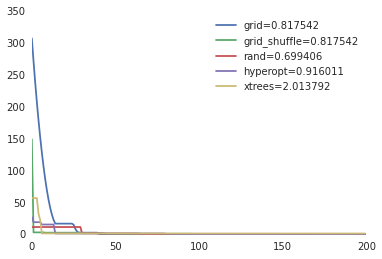

In [42]:
num_dims = 2
eval_fn = branin_hoo

results = []
for name, search_fn in names_and_search_fns:
    with timer(name):
        res = search_fn(evaluation_fn=eval_fn, num_dims=num_dims)
    results.append((name, res))

plot_bests(results)

grid took 0.004512s
grid_shuffle took 0.002171s
rand took 0.006213s
hyperopt took 66.283209s
xtrees took 15.152006s


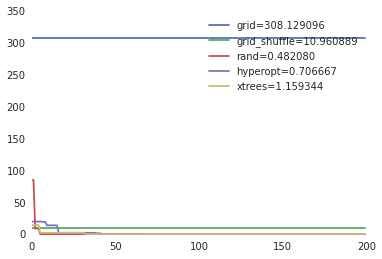

In [43]:
num_dims = 100
eval_fn = branin_hoo_with_useless_dimensions(num_dims)

results = []
for name, search_fn in names_and_search_fns:
    with timer(name):
        res = search_fn(evaluation_fn=eval_fn, num_dims=num_dims)
    results.append((name, res))

plot_bests(results)